## INFERENCE MODEL
Setup inference model

In [1]:
import os, sys
sys.path.append(os.path.split(sys.path[0])[0])

#Dependencies
import h5py
import math
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
import sbi.analysis as analysis
from sbi.utils.get_nn_models import posterior_nn  # For SNLE: likelihood_nn(). For SNRE: classifier_nn()
from scipy import signal, stats as spstats
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F

#Project Imports
import config.params as params
import config.paths as paths
from stylized_module.base.passive_model_soma_injection import run_pm_simulation
from stylized_module.base.active_model_synapse_input import run_am_simulation
from stylized_module.models.SummaryStats2D import Stats, cat_output
from utils.metrics.corrcoef import corrcoef, max_corrcoef
from utils.plotting.plot_results import plot_LFP_traces,plot_LFP_heatmap
from utils.spike_window import first_pk_tr, get_spike_window
from utils.transform.distribution_transformation import norm2unif, range2logn, norm2logn, logds_norm2unif, logds_norm2logn

Helper Functions

In [2]:
rng = np.random.default_rng(123412)

def passive_model(param,whole_trace=False):
    #Replace theta with random number
    theta = [rng.uniform(low=params.IM_THETA_BOUNDS[0], high=params.IM_THETA_BOUNDS[1])]
    sim.set_loc_param(torch.cat((torch.zeros(1),param[:2], torch.tensor(theta), param[2:4])))
    scalVal = 1 #10 ** param[5]
    sim.set_scale(scalVal)
    sim.set_geo_param(param[4:])
    sim.create_cells()
    sim.run()
    lfp = sim.get_lfp().T
    filtered_lfp = signal.lfilter(filt_b,filt_a,lfp,axis=0) # filter along row of the lfp 2d-array, if each row is a channel
    if not whole_trace:
        start,end = get_spike_window(filtered_lfp,win_size=params.PM_WINDOW_SIZE,align_at=fst_idx)
        filtered_lfp = filtered_lfp[start:end,:]
    return filtered_lfp

def active_model(param,whole_trace=False):
#     biophys = [param[0],-1,-1,param[1],-1,param[2],-1]
#     sim.set_biophys(biophys)
    
    #Replace alpha with random number
    alpha = rng.uniform(low=params.IM_ALPHA_BOUNDS[0], high=params.IM_ALPHA_BOUNDS[1])
    d = param[0],
    theta = param[1],
    x = d * np.sin(theta)
    z = d * np.cos(theta)
    
    numpy_list = np.squeeze(np.array([
        x, #x
        [0], #y
        z, #z
        [alpha], #alpha
        [param[2]], #h
        [param[3]], #phi
    ]))
#     print(numpy_list)
    sim.set_loc_param(torch.from_numpy(numpy_list))
    
    geo_list = np.array([
        6.0,
        param[4],
        0.5,
        0.5,
        0.5,
        200.
    ])

    sim.set_geo_param(torch.from_numpy(geo_list))

    scalVal = 1 #10 ** param[5]
    sim.set_scale(scalVal)
    
    sim.set_gmax(params.GT_GMAX)
#     scalVal = 10 ** param[4]
    sim.set_scale(scalVal)
    sim.create_cells()
    sim.run()
    lfp = sim.get_lfp().T
    filtered_lfp = signal.lfilter(filt_b,filt_a,lfp,axis=0) # filter along row of the lfp 2d-array, if each row is a channel
    if not whole_trace:
        start,end = get_spike_window(filtered_lfp,win_size=params.AM_WINDOW_SIZE,align_at=fst_idx)
        filtered_lfp = filtered_lfp[start:end,:]
    return filtered_lfp


def simulation(sim_params):
    lfp = passive_model(sim_params) if params.ACTIVE_CELL is False else active_model(sim_params)
    return cat_output(lfp)

In [3]:
filt_b,filt_a = signal.butter(params.IM_BUTTERWORTH_ORDER,
                              params.IM_CRITICAL_FREQUENCY,
                              params.IM_BANDFILTER_TYPE,
                              fs=params.IM_FILTER_SAMPLING_RATE)

sim, window_size, x0_trace, t0 = run_pm_simulation() if params.ACTIVE_CELL is False else run_am_simulation()

fst_idx = first_pk_tr(x0_trace)

In [4]:
simulator, prior = prepare_for_sbi(simulation, params.IM_PRIOR_DISTRIBUTION)
x_o = cat_output(x0_trace)
print(x_o.shape)

<ipython-input-2-b49788d39a3e>:27: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  x = d * np.sin(theta)


torch.Size([72991])


In [5]:
# instantiate the neural density estimator
density_estimator_build_fun = posterior_nn(
    model=params.IM_POSTERIOR_MODEL_ESTIMATOR,
    embedding_net=params.IM_EMBEDDED_NETWORK,
    hidden_features=params.IM_POSTERIOR_MODEL_HIDDEN_LAYERS
)

inference = SNPE(
    prior=prior,
    density_estimator=density_estimator_build_fun,
    show_progress_bars=True
)

In [6]:
# posteriors = []
# proposal = prior

# for i in range(params.IM_NUMBER_OF_ROUNDS):
#     # if i == 0:
#     #     theta = torch.Tensor(np.load("theta_pyro_0.npy"))
#     #     x = torch.Tensor(np.load("x_pyro_0.npy"))
#     # elif i == 1:
#     #     theta = torch.Tensor(np.load("theta_pyro_1.npy"))
#     #     x = torch.Tensor(np.load("x_pyro_1.npy"))
#     # else:
#     #     theta, x = simulate_for_sbi(
#     #         simulator,
#     #         proposal,
#     #         num_simulations=params.IM_NUMBER_OF_SIMULATIONS
#     #     )

#     theta, x = simulate_for_sbi(
#             simulator,
#             proposal,
#             num_simulations=params.IM_NUMBER_OF_SIMULATIONS
#         )
    
#     np.save("theta_pyro_" + str(i) + ".npy", theta)
#     np.save("x_pyro_" + str(i) + ".npy", x)
    
#     density_estimator = inference.append_simulations(np.squeeze(theta), x, proposal=proposal).train()
    
#     posterior = inference.build_posterior(
#         density_estimator, 
#         sample_with="mcmc", 
#         mcmc_method="nuts", 
#         mcmc_parameters={'num_chains': 8, 'thin': 10, 'warmup_steps': 20}
#     )
    
#     with open(paths.POSTERIOR_SAVE + str(i) + "_pyro_post.pkl", "wb") as handle:
#         pickle.dump(posterior, handle)
        
#     with open(paths.POSTERIOR_SAVE + str(i) + "_pyro_de.pkl", "wb") as handle:
#         pickle.dump(density_estimator, handle)
        
#     posteriors.append(posterior)
#     proposal = posterior.set_default_x(x_o)
    
# inference._summary_writer = None
# inference._build_neural_net = None
# with open(paths.INFERENCER_SAVE + str(i) + "_pyro.pkl", "wb") as handle:
#     pickle.dump(inference, handle)

with open(paths.POSTERIOR_SAVE + "1_pyro_post.pkl", "rb") as handle:
    posterior = pickle.load(handle)

Warmup [1]:   0%|          | 0/1278 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1278 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/1278 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/1278 [00:00, ?it/s]

Warmup [5]:   0%|          | 0/1278 [00:00, ?it/s]

Warmup [6]:   0%|          | 0/1278 [00:00, ?it/s]

Warmup [7]:   0%|          | 0/1278 [00:00, ?it/s]

Warmup [8]:   0%|          | 0/1278 [00:00, ?it/s]

(array([  1.,   2.,   7.,  12.,  24.,  47., 173., 312., 305., 117.]),
 array([-17.53034 , -16.575039, -15.619739, -14.664438, -13.709138,
        -12.753838, -11.798536, -10.843236,  -9.887936,  -8.932634,
         -7.977334], dtype=float32),
 <BarContainer object of 10 artists>)

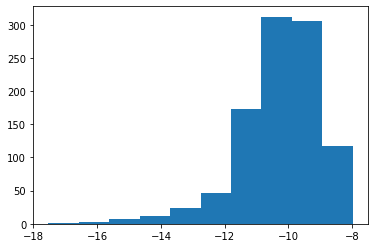

In [7]:
# samples = posterior.sample((1000,), x=x_o)#, sample_with='mcmc') #, sample_with_mcmc=True
samples = posterior.sample(
    (1000,), 
    x=x_o, 
    sample_with='mcmc',
    mcmc_method="nuts", 
    mcmc_parameters={'num_chains': 8, 'thin': 10, 'warmup_steps': 20}
)

#posterior.leakage_correction(x_o, num_rejection_samples=1000)
log_probability = posterior.log_prob(samples,x=x_o, norm_posterior=False) #, norm_posterior=False
# log_prob_t = log_probability
# for i in range(6):
#     log_prob_t += logds_norm2unif(samples[:,i], params.IM_PARAMETER_BOUNDS[i][0], params.IM_PARAMETER_BOUNDS[i][1])
# for i in range(6,11):
#     if i == 6:
#         m,s=range2logn(params.IM_PARAMETER_BOUNDS[i][0], params.IM_PARAMETER_BOUNDS[i][1], n_sigma=3)
#     else:
#         m,s=range2logn(params.IM_PARAMETER_BOUNDS[i][0], params.IM_PARAMETER_BOUNDS[i][1])
#     log_prob_t += logds_norm2logn(samples[:,i], m, s)
plt.hist(log_probability.numpy())

In [8]:
with open(paths.POSTERIOR_SAVE + "log_probability.pkl", "wb") as handle:
    pickle.dump(log_probability, handle)

In [9]:
sample_idx = np.argmax(log_probability)
# samples_t = torch.clone(samples)
# for i in range(6):
#     samples_t[:,i] = torch.from_numpy(norm2unif(samples[:,i], params.IM_PARAMETER_BOUNDS[i][0], params.IM_PARAMETER_BOUNDS[i][1]))
# for i in range(6,11):
#     if i == 6:
#         m,s=range2logn(params.IM_PARAMETER_BOUNDS[i][0], params.IM_PARAMETER_BOUNDS[i][1], n_sigma=3)
#     else:
#         m,s=range2logn(params.IM_PARAMETER_BOUNDS[i][0], params.IM_PARAMETER_BOUNDS[i][1])
#     samples_t[:,i] = norm2logn(samples[:,i], m, s)
predicted_post = samples[sample_idx]
predicted_post

tensor([ 2.7114e+01,  8.7004e-01, -6.8701e-01,  2.3577e-02,  1.1096e+02])

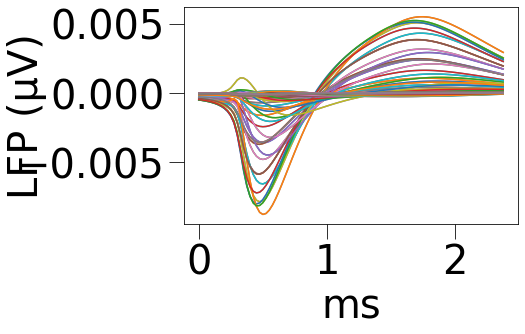

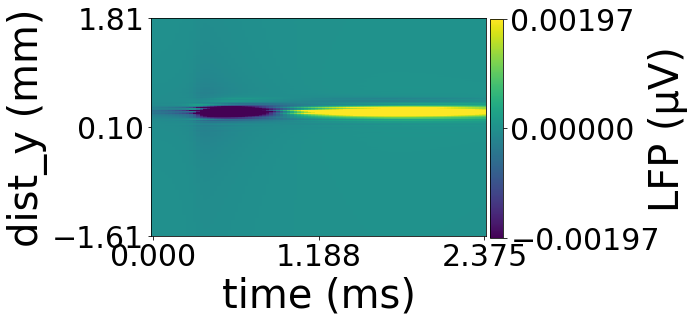

In [10]:
save_xo = params.IM_SAVE_X0
# save_xo = 'x_0_traces.pdf'
fig,ax = plot_LFP_traces(t0,x0_trace,savefig=params.IM_SAVE_X0)
# save_xo = 'x_0_HTmap.pdf'
elec_idx = slice(30,-10)
fig,ax = plot_LFP_heatmap(t0,params.IM_Y_DISTANCE[elec_idx],x0_trace[:,elec_idx],vlim='auto',savefig=params.IM_SAVE_X0)

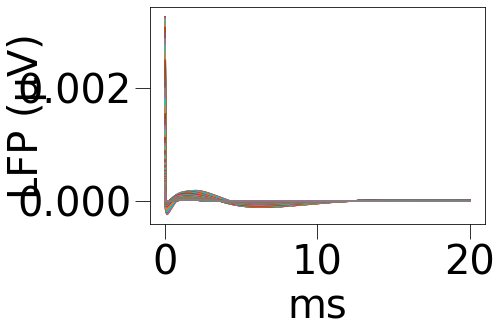

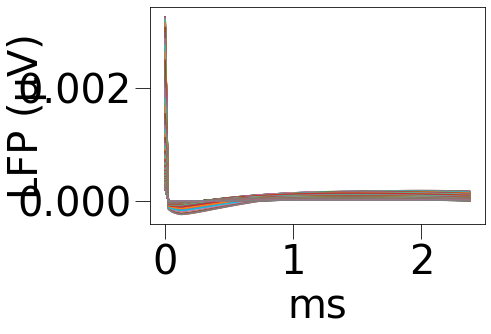

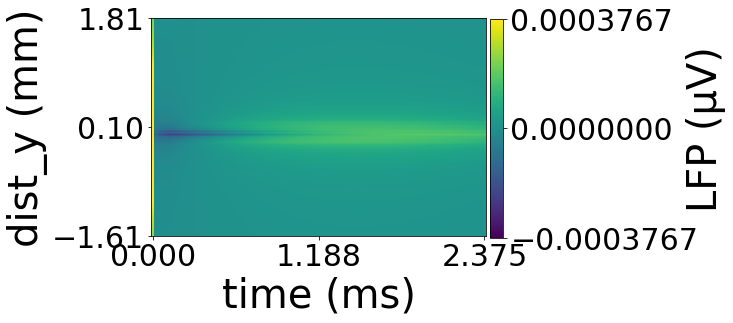

In [11]:
# predicted_lfp = passive_model(params.IM_RANDOM_SAMPLE,whole_trace=True)
predicted_lfp = passive_model(predicted_post,whole_trace=True) if params.ACTIVE_CELL is False else active_model(predicted_post, whole_trace=True)

fig,ax = plot_LFP_traces(sim.t(),predicted_lfp)
start,end = get_spike_window(predicted_lfp,win_size=params.AM_WINDOW_SIZE,align_at=fst_idx)
predicted_lfp_win = predicted_lfp[start:end,:]

savefig = paths.PASSIVE_INFERENCE_SAVE_TRACES if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_SAVE_TRACES
fig,ax = plot_LFP_traces(t0,
                         predicted_lfp_win,
                         savefig=savefig)

savefig = paths.PASSIVE_INFERENCE_SAVE_HEATMAPS if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_SAVE_HEATMAPS
fig,ax = plot_LFP_heatmap(t0,
                          params.IM_Y_DISTANCE[elec_idx],
                          predicted_lfp_win[:,elec_idx],
                          vlim='auto',
                          savefig=savefig)

In [12]:
max_corr, max_ind = max_corrcoef(x0_trace,predicted_lfp)
print(max_corr,max_ind)
max_corr, max_ind = max_corrcoef(x0_trace,predicted_lfp_win)
print(max_corr,max_ind)

0.20757290253768995 465
0.03170105052053335 0


In [13]:
hf_file = paths.PASSIVE_INFERENCE_RESULTS_DATA if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_RESULTS_DATA
hf = h5py.File(hf_file, 'w')
hf.create_dataset('LFP',data=predicted_lfp)
hf.create_dataset('samples',data=samples.numpy())
hf.create_dataset('log_prob',data=log_probability.numpy())
hf.close()

mat_file = paths.PASSIVE_INFERENCE_RESULTS_MATLAB_DATA if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_RESULTS_MATLAB_DATA
scipy.io.savemat(mat_file,
                 {'LFP':predicted_lfp_win[:,elec_idx],'t':t0,'y_dist':params.IM_Y_DISTANCE[elec_idx]})

mat_file = paths.PASSIVE_INFERENCE_RESULTS_X0_MATLAB_DATA if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_RESULTS_X0_MATLAB_DATA
scipy.io.savemat(mat_file,
                 {'LFP':x0_trace[:,elec_idx],'t':t0,'y_dist':params.IM_Y_DISTANCE[elec_idx]})

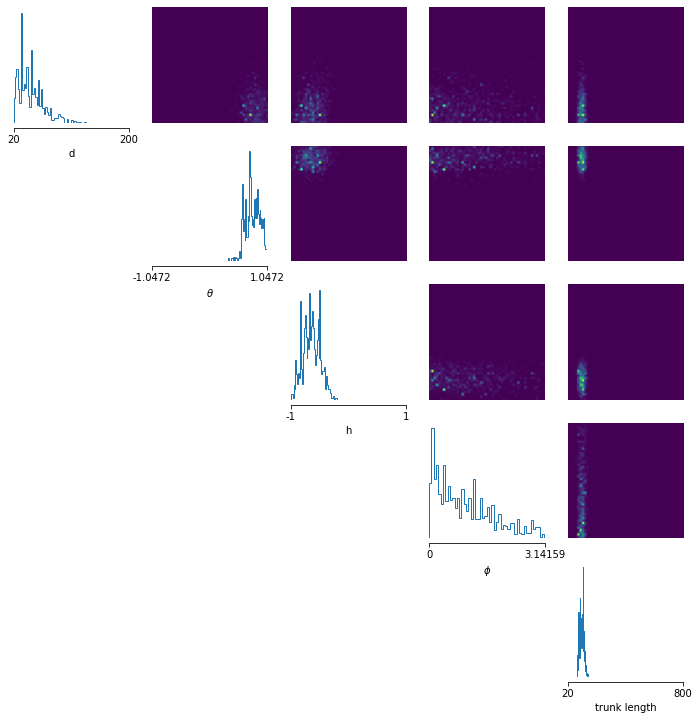

In [14]:
labels_params = [r'd',r'$\theta$',r'h',r'$\phi$',r'trunk length']
bounds = [[20,200],[-(np.pi/3),np.pi/3],[-1,1],[0,np.pi],[20,800]]
fig, axes = analysis.pairplot(samples,
                           limits = bounds,# params.IM_PARAMETER_BOUNDS,
                           ticks = bounds,#params.IM_PARAMETER_BOUNDS,
                           figsize=(12,12),
                           #points=true_params,
                           points_offdiag={'markersize': 6},
                           labels = labels_params,
                           points_colors='r')

IndexError: index 5 is out of bounds for axis 0 with size 5

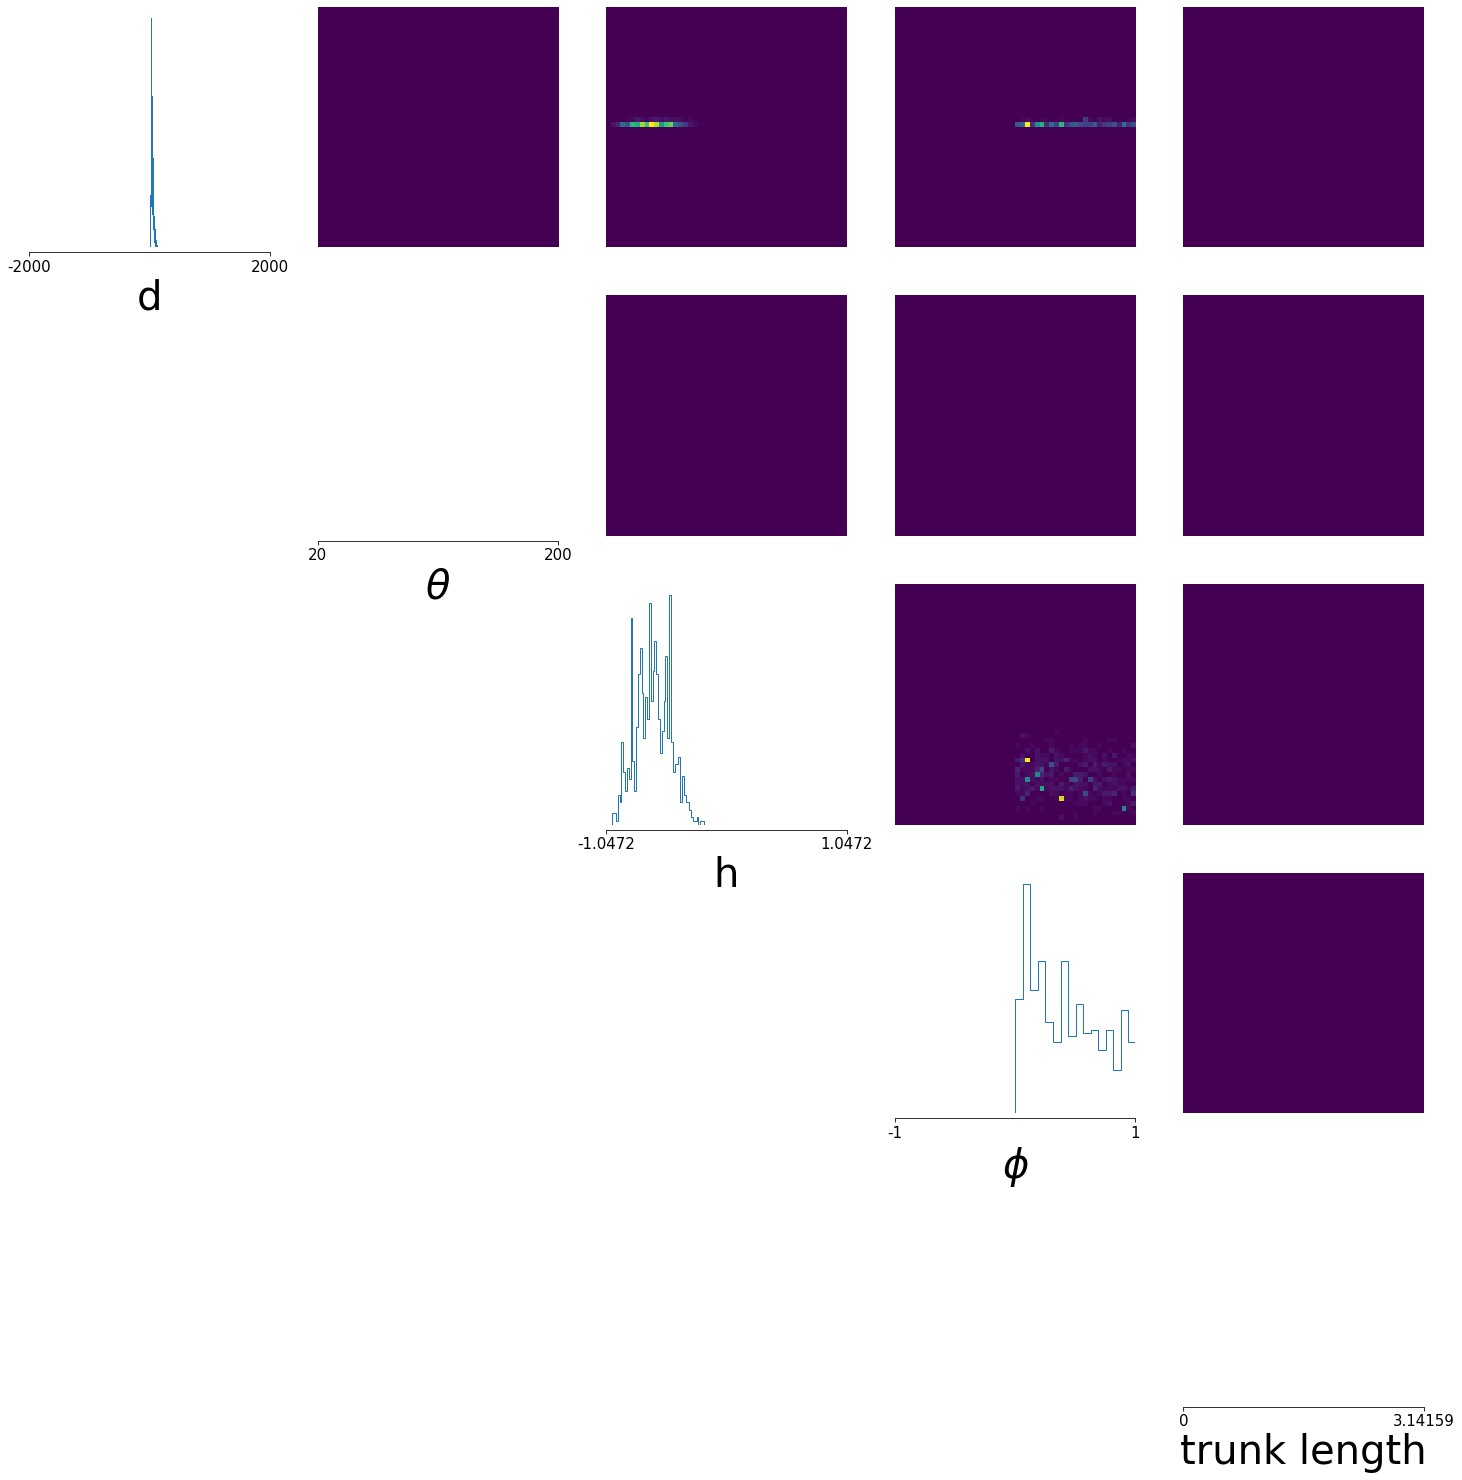

In [15]:
%matplotlib inline

# labels_params = params.IM_GRAPHING_LABELS
bounds_ticks = params.IM_PARAMETER_BOUNDS
bounds_ticks[2] = bounds_ticks[4] = [0,3.14]
bounds = [[-2000,2000],[20,200],[-(np.pi/3),np.pi/3],[-1,1],[0,np.pi],[3,12],[20,800],[0.2,1.0],[0.2,1.0],[0.2,1.0],[100,300]]
fig, axes = analysis.pairplot(samples,
                           limits = bounds, #params.IM_PARAMETER_BOUNDS,
                           ticks = bounds, #params.IM_PARAMETER_BOUNDS,
                           figsize=(25,25),
                           #points=true_params,
                           points_offdiag={'markersize': 6},
                           labels = labels_params,
                           points_colors='r')

# axes[4][4].set_xlabel('\u03BB',fontsize = 40)
for i in range(len(params.IM_PARAMETER_BOUNDS)):
    axes[i][i].tick_params('x',labelsize=15)
    axes[i][i].xaxis.label.set_fontsize(40)

for i,b in enumerate(params.IM_PARAMETER_BOUNDS):
    axes[i][i].set_xticklabels([str(b[0]),str(b[1])],fontsize=30)

    
save_file = paths.PASSIVE_INFERENCE_SAVE_KDE if params.ACTIVE_CELL is False else paths.ACTIVE_INFERENCE_SAVE_KDE
plt.savefig(save_file,bbox_inches='tight',transparent=True)

In [ ]:
points = torch.Tensor([[350],[50],[np.pi/4], [0.0], [0.8], [6.0], [400.0], [0.5], [0.5], [0.5], [200.0]]).reshape(-1,11)
labels_params = params.IM_GRAPHING_LABELS #= [r'y',r'd',r'$\theta$',r'h',r'$\phi$',r'soma radius',r'trunk length',r'trunk radius',r'basal radius',r'tuft radius',r'basal length']
bounds = [[-2000,2000],[20,200],[-(np.pi/3),np.pi/3],[-1,1],[0,np.pi],[3,12],[20,800],[0.2,1.0],[0.2,1.0],[0.2,1.0],[100,300]]
fig, axes = analysis.pairplot(samples,
                           limits = bounds,#params.IM_PARAMETER_BOUNDS,
                           ticks = bounds,#params.IM_PARAMETER_BOUNDS,
                           figsize=(12,12),
                           points=points,
                           points_offdiag={'markersize': 6},
                           labels = labels_params,
                           points_colors='r')